In [1]:
import numpy as np
import pandas as pd
import novosparc
import matplotlib
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
%matplotlib inline

In [2]:
data_path = 'raw/expr_matrix_10day_log_normalized.txt'   # 11566 cells and 2000 genes
output_folder = 'out'
tissue_path = 'raw/myshape.npy'
hvg_path = 'raw/high_variable_genes_10day.txt'

location_marker = 'raw/dge_full.txt'

In [3]:
# load dataset:  expression matrix   col-gene,row-cell
dataset = novosparc.io.load_data(data_path)

In [4]:
dataset.shape

(11566, 30230)

In [5]:
# just to view gene names and the matrix
gene_names = np.asarray(dataset.var.index.tolist())
dge = dataset.X

In [6]:
dge.shape

(11566, 30230)

In [7]:
# save the set to dataset.raw
dataset.raw = dataset

In [8]:
# select only genes in hvg_list
dataset, hvg = novosparc.pp.subset_to_hvg(dataset, hvg_file = hvg_path) # dataset[:,dataset.var.index.isin(gene_list)], gene_list

In [9]:
dataset.shape

(11566, 2000)

In [10]:
# load target space
# locations = novosparc.geometry.create_target_space_from_image(tissue_path) #

locations = np.load(tissue_path)

# # just to check f atlas is correct
# atlas = np.load('res/xxx.npy')
# locations = locations[atlas==1]
locations.shape

(68994, 2)

In [11]:
# subsample the locations to save effort -- low resolution now
seed = np.random.choice(locations.shape[0], 3000)  ### -------- later to select markers
locations = locations[seed, :]

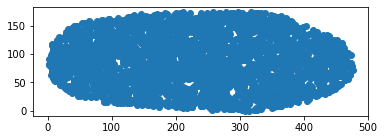

In [12]:
plt.figure(figsize=(6,2))
plt.scatter(locations[:, 1], locations[:, 0])
plt.show()

### Reconstruction
https://github.com/rajewsky-lab/novosparc/blob/master/reconstruct_drosophila_embryo_tutorial.ipynb

In [13]:
#Reconstruct the tissue de novo/with marker
tissue = novosparc.cm.Tissue(dataset=dataset, locations=locations, output_folder=output_folder)

In [14]:
atlas_path = 'raw/atlas.txt'
insitu_genes = np.genfromtxt(atlas_path, usecols=range(29), dtype='str', max_rows=1)

In [15]:
# find indices of marker genes in dge dataset
gene_names = tissue.gene_names
markers_in_sc = np.array([], dtype='int')
markers_in_sc_name = []
for marker in insitu_genes:
    marker_index = np.where(gene_names == marker)[0]
    if len(marker_index) > 0:
        markers_in_sc = np.append(markers_in_sc, marker_index[0])
        markers_in_sc_name.append(marker)

In [16]:
# load atlas matrix
# make sure atlas_matrix.shape[1]==tissue.dge[:, markers_in_sc].shape[1] (or dataset.dge)
atlas_matrix = pd.read_csv(atlas_path,sep='\t')
atlas_matrix = atlas_matrix[markers_in_sc_name]
atlas_matrix = atlas_matrix.to_numpy()

In [ ]:
tissue.setup_reconstruction(markers_to_use=markers_in_sc, insitu_matrix=atlas_matrix, num_neighbors_s=5, num_neighbors_t=5)

Setting up for reconstruction ... 

In [ ]:
tissue.reconstruct(alpha_linear=0, epsilon=5e-3)

In [ ]:
tissue.calculate_spatially_informative_genes()

In [ ]:
sdge_hvg = tissue.sdge

In [ ]:
sdge = tissue.calculate_sdge_for_all_genes()

In [ ]:
# plot some genes
gene_list_to_plot = [
    'SMED30011970', #eye and head, dd_4427
    'SMED30030642', #pharynx
    'SMED30001882',#brain and phx
    'SMED30005457', #super strong; big cells around the gut
    'SMED30000013', #gut
    'SMED30010123', #protonephridia
    'SMED30016244', #secretory cells?
    'SMED30011490' #epithelium
]

In [ ]:
gene_dict = {
    'SMED30011970':'eye and head',
    'SMED30030642':'pharynx',
    'SMED30001882':'brain and phx',
    'SMED30005457':'big cells-gut(++)',
    'SMED30000013':'gut',
    'SMED30010123':'protonephridia',
    'SMED30016244':'secretory cells',
    'SMED30011490':'epithelium'
}

In [ ]:
mylen=len(gene_list_to_plot)
plt.figure(figsize=(2*mylen,6))
for i in range(len(gene_list_to_plot)):
        plt.subplot(1,mylen,i+1)
        plt.scatter(locations[:, 0], locations[:, 1], c=sdge[np.argwhere(gene_names == gene_list_to_plot[i])[0], :].flatten(), s=1)
        plt.title(gene_dict[gene_list_to_plot[i]])
        plt.axis('off')
plt.show()